In [2]:
from natsort import natsorted
import argparse
import os
from collections import OrderedDict
import io
import contextlib
import itertools

import shutil
import pickle
import numpy as np
import mmcv
from mmdet.datasets.api_wrappers import COCO, COCOeval

from base_config import get_config
from test import map_test
from mmdet_tools import mmdet_test

In [3]:
experiment_names = ['baseline']
pretrain_percentages = range(10, 91, 10)
experiment_names += ['pretrain' + str(percent) for percent in pretrain_percentages]
experiment_names

['baseline',
 'pretrain10',
 'pretrain20',
 'pretrain30',
 'pretrain40',
 'pretrain50',
 'pretrain60',
 'pretrain70',
 'pretrain80',
 'pretrain90']

In [4]:
experiment_checkpoints = []

for experiment_name in experiment_names:
  checkpoints = os.listdir(os.path.join('../vinbig_output', experiment_name))
  checkpoints = natsorted(checkpoints)
  checkpoints = [p for p in checkpoints if 'epoch_' in p]
  checkpoint = os.path.join('../vinbig_output', experiment_name, checkpoints[-1])
  experiment_checkpoints.append(checkpoint)

experiment_checkpoints

['../vinbig_output/baseline/epoch_15.pth',
 '../vinbig_output/pretrain10/epoch_15.pth',
 '../vinbig_output/pretrain20/epoch_15.pth',
 '../vinbig_output/pretrain30/epoch_15.pth',
 '../vinbig_output/pretrain40/epoch_15.pth',
 '../vinbig_output/pretrain50/epoch_15.pth',
 '../vinbig_output/pretrain60/epoch_15.pth',
 '../vinbig_output/pretrain70/epoch_15.pth',
 '../vinbig_output/pretrain80/epoch_15.pth',
 '../vinbig_output/pretrain90/epoch_15.pth']

In [142]:
def print_log(msg, logger):
    pass
    #print(msg)

def evaluate(dataset,
                results,
                metric='bbox',
                logger=None,
                jsonfile_prefix=None,
                classwise=False,
                proposal_nums=(100, 300, 1000),
                iou_thrs=None,
                metric_items=None):
    """Evaluation in COCO protocol.
    Args:
        results (list[list | tuple]): Testing results of the dataset.
        metric (str | list[str]): Metrics to be evaluated. Options are
            'bbox', 'segm', 'proposal', 'proposal_fast'.
        logger (logging.Logger | str | None): Logger used for printing
            related information during evaluation. Default: None.
        jsonfile_prefix (str | None): The prefix of json files. It includes
            the file path and the prefix of filename, e.g., "a/b/prefix".
            If not specified, a temp file will be created. Default: None.
        classwise (bool): Whether to evaluating the AP for each class.
        proposal_nums (Sequence[int]): Proposal number used for evaluating
            recalls, such as recall@100, recall@1000.
            Default: (100, 300, 1000).
        iou_thrs (Sequence[float], optional): IoU threshold used for
            evaluating recalls/mAPs. If set to a list, the average of all
            IoUs will also be computed. If not specified, [0.50, 0.55,
            0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] will be used.
            Default: None.
        metric_items (list[str] | str, optional): Metric items that will
            be returned. If not specified, ``['AR@100', 'AR@300',
            'AR@1000', 'AR_s@1000', 'AR_m@1000', 'AR_l@1000' ]`` will be
            used when ``metric=='proposal'``, ``['mAP', 'mAP_50', 'mAP_75',
            'mAP_s', 'mAP_m', 'mAP_l']`` will be used when
            ``metric=='bbox' or metric=='segm'``.
    Returns:
        dict[str, float]: COCO style evaluation metric.
    """
    
    metrics = metric if isinstance(metric, list) else [metric]
    allowed_metrics = ['bbox', 'segm', 'proposal', 'proposal_fast']
    for metric in metrics:
        if metric not in allowed_metrics:
            raise KeyError(f'metric {metric} is not supported')
    if iou_thrs is None:
        iou_thrs = np.linspace(
            .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    if metric_items is not None:
        if not isinstance(metric_items, list):
            metric_items = [metric_items]

    result_files, tmp_dir = dataset.format_results(results, jsonfile_prefix)

    eval_results = OrderedDict()
    cocoGt = dataset.coco

    results_per_category = []

    for metric in metrics:
        msg = f'Evaluating {metric}...'
        if logger is None:
            msg = '\n' + msg
        print_log(msg, logger=logger)

        if metric == 'proposal_fast':
            ar = dataset.fast_eval_recall(
                results, proposal_nums, iou_thrs, logger='silent')
            log_msg = []
            for i, num in enumerate(proposal_nums):
                eval_results[f'AR@{num}'] = ar[i]
                log_msg.append(f'\nAR@{num}\t{ar[i]:.4f}')
            log_msg = ''.join(log_msg)
            print_log(log_msg, logger=logger)
            continue

        iou_type = 'bbox' if metric == 'proposal' else metric
        if metric not in result_files:
            raise KeyError(f'{metric} is not in results')
        try:
            predictions = mmcv.load(result_files[metric])
            if iou_type == 'segm':
                # Refer to https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L331  # noqa
                # When evaluating mask AP, if the results contain bbox,
                # cocoapi will use the box area instead of the mask area
                # for calculating the instance area. Though the overall AP
                # is not affected, this leads to different
                # small/medium/large mask AP results.
                for x in predictions:
                    x.pop('bbox')
                warnings.simplefilter('once')
                warnings.warn(
                    'The key "bbox" is deleted for more accurate mask AP '
                    'of small/medium/large instances since v2.12.0. This '
                    'does not change the overall mAP calculation.',
                    UserWarning)
            cocoDt = cocoGt.loadRes(predictions)
        except IndexError:
            print_log(
                'The testing results of the whole dataset is empty.',
                logger=logger,
                level=logging.ERROR)
            break

        cocoEval = COCOeval(cocoGt, cocoDt, iou_type)
        cocoEval.params.catIds = dataset.cat_ids
        cocoEval.params.imgIds = dataset.img_ids
        cocoEval.params.maxDets = list(proposal_nums)
        cocoEval.params.iouThrs = iou_thrs
        # mapping of cocoEval.stats
        coco_metric_names = {
            'mAP': 0,
            'mAP_50': 1,
            'mAP_75': 2,
            'mAP_s': 3,
            'mAP_m': 4,
            'mAP_l': 5,
            'AR@100': 6,
            'AR@300': 7,
            'AR@1000': 8,
            'AR_s@1000': 9,
            'AR_m@1000': 10,
            'AR_l@1000': 11
        }
        if metric_items is not None:
            for metric_item in metric_items:
                if metric_item not in coco_metric_names:
                    raise KeyError(
                        f'metric item {metric_item} is not supported')

        if metric == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.evaluate()
            cocoEval.accumulate()

            # Save coco summarize print information to logger
            redirect_string = io.StringIO()
            with contextlib.redirect_stdout(redirect_string):
                cocoEval.summarize()
            print_log('\n' + redirect_string.getvalue(), logger=logger)

            if metric_items is None:
                metric_items = [
                    'AR@100', 'AR@300', 'AR@1000', 'AR_s@1000',
                    'AR_m@1000', 'AR_l@1000'
                ]

            for item in metric_items:
                val = float(
                    f'{cocoEval.stats[coco_metric_names[item]]:.3f}')
                eval_results[item] = val
        else:
            cocoEval.evaluate()
            cocoEval.accumulate()

            # Save coco summarize print information to logger
            redirect_string = io.StringIO()
            with contextlib.redirect_stdout(redirect_string):
                cocoEval.summarize()
            print_log('\n' + redirect_string.getvalue(), logger=logger)
            
            if classwise:  # Compute per-category AP
                # Compute per-category AP
                # from https://github.com/facebookresearch/detectron2/
                precisions = cocoEval.eval['precision']
                # precision: (iou, recall, cls, area range, max dets)
                assert len(dataset.cat_ids) == precisions.shape[2]

                for idx, catId in enumerate(dataset.cat_ids):
                    # area range index 0: all area ranges
                    # max dets index -1: typically 100 per image
                    nm = dataset.coco.loadCats(catId)[0]
                    precision = precisions[:, :, idx, 0, -1]
                    precision = precision[precision > -1]
                    if precision.size:
                        ap = np.mean(precision)
                    else:
                        ap = float('nan')
                    results_per_category.append(
                        (f'{nm["name"]}', float(ap)))

                num_columns = min(6, len(results_per_category) * 2)
                results_flatten = list(
                    itertools.chain(*results_per_category))
                headers = ['category', 'AP'] * (num_columns // 2)
                results_2d = itertools.zip_longest(*[
                    results_flatten[i::num_columns]
                    for i in range(num_columns)
                ])

            if metric_items is None:
                metric_items = [
                    'mAP', 'mAP_50', 'mAP_75', 'mAP_s', 'mAP_m', 'mAP_l'
                ]

            for metric_item in metric_items:
                key = f'{metric}_{metric_item}'
                val = float(
                    f'{cocoEval.stats[coco_metric_names[metric_item]]:.3f}'
                )
                eval_results[key] = val
            ap = cocoEval.stats[:6]
            eval_results[f'{metric}_mAP_copypaste'] = (
                f'{ap[0]:.3f} {ap[1]:.3f} {ap[2]:.3f} {ap[3]:.3f} '
                f'{ap[4]:.3f} {ap[5]:.3f}')
    if tmp_dir is not None:
        tmp_dir.cleanup()
    return eval_results, results_per_category

In [145]:
results = {}

results_dir = 'results'
if os.path.exists(results_dir):
  shutil.rmtree(results_dir)

os.makedirs(results_dir)

results_avg = []
results_avg_ar = []
results_classwise = []

for experiment_name, checkpoint in zip(experiment_names, experiment_checkpoints):
  cfg = get_config()
  args = argparse.Namespace(eval='bbox', out='results/' + experiment_name + '.pkl', checkpoint=None, work_dir=results_dir, fuse_conv_bn=None, 
    gpu_ids=None, format_only=None, show=None, show_dir=None, show_score_thr=0.3, gpu_collect=None,
    tmpdir=None, cfg_options=None, options=None, launcher='none', eval_options=None, local_rank=0)
  dataset, outputs = mmdet_test.get_outputs(cfg, checkpoint, args)
  metrics, results_per_category = evaluate(dataset, outputs, metric='bbox', classwise=True)
  metrics_ar, _ = evaluate(dataset, outputs, metric='proposal')
  results_avg.append(metrics)
  results_avg_ar.append(metrics_ar)
  results_classwise.append(results_per_category)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/baseline/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 52.6 task/s, elapsed: 17s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.44s).
Accumulating evaluation results...
DONE (t=0.42s).
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...
DONE (t=0.27s).
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/pretrain10/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 53.1 task/s, elapsed: 17s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluat

([<matplotlib.axis.XTick at 0x7f2dccca62e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

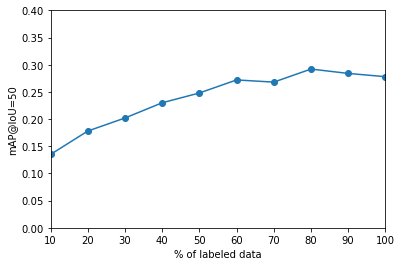

In [7]:
import matplotlib.pyplot as plt
percentages = [100] + [100 - p for p in pretrain_percentages]
map_50s = [r['bbox_mAP_50'] for r in results_avg]

plt.plot(percentages, map_50s, '-o')
plt.ylim(0, 0.4)
plt.xlim(10, 100)
plt.ylabel('mAP@IoU=50')
plt.xlabel('% of labeled data')
plt.xticks(np.arange(10, 101, 10))

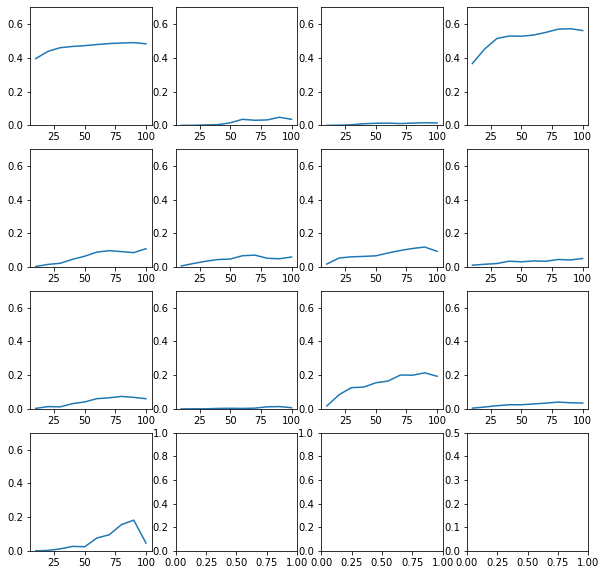

In [8]:
classes = [key for key, _ in results_classwise[0]]
results_classwise_dict = [dict(r) for r in results_classwise]
class_to_results = {}
for class_name in classes:
    class_to_results[class_name] = [r[class_name] for r in results_classwise_dict]

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
class_names = list(class_to_results.keys())
axs = axs.flatten()
plt.ylim(0, 0.5)
for i in range(len(axs)):
    if i >= 13:
        break
    
    ax = axs[i]
    class_name = class_names[i]
    aps = class_to_results[class_name]
    aps = list(map(float, aps))
    ax.plot(percentages, aps)
    ax.set_ylim(0, 0.7)

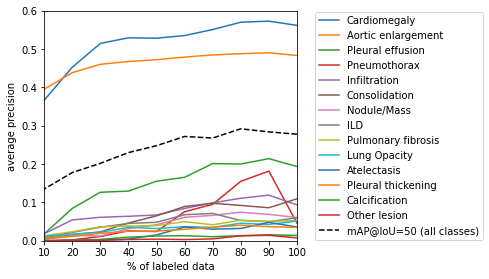

In [166]:
import seaborn as sns
from matplotlib.colors import ListedColormap

items = list(class_to_results.items())
items = [(k, list(map(float, aps))) for (k, aps) in items]
items.sort(key=lambda i: max(i[1]), reverse=True)

fig, ax = plt.subplots(figsize=(7, 4))

evenly_spaced_interval = np.linspace(0, 1, len(items))
cmap = ListedColormap(sns.color_palette(n_colors=14))
colors = [cmap(x) for x in evenly_spaced_interval]

for (i, (class_name, aps)) in enumerate(items):
  label = class_name.replace('_', ' ')
  plt.plot(percentages, aps, label=label, color=colors[i])

plt.plot(percentages, map_50s, '--', color='black', label='mAP@IoU=50 (all classes)')

plt.ylim(0, 0.6)

plt.ylabel('average precision')
plt.xlabel('% of labeled data')
plt.xticks(np.arange(10, 101, 10))
plt.xlim(10, 100)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()

plt.savefig('figures/map_graph.png')

In [85]:
from test import get_training_datasets, _classes
from mmdet.datasets import build_dataset
from train import get_config

img_norm_cfg = dict(
  mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

pipeline = [
  dict(type='LoadImageFromFile'),
  dict(type='LoadAnnotations', with_bbox=True),
  dict(type='RandomFlip', flip_ratio=0.),
  dict(type='Resize', img_scale=(512, 512), keep_ratio=True),
  dict(type='Normalize', **img_norm_cfg),
  dict(type='Pad', size_divisor=32),
  dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

cfg.data.train['dataset'].pipeline = pipeline
cfg.data.train['dataset'].take_first_percent = 1
cfg.data.train['take_first_percent'] = 1
cfg.data.val.pipeline = pipeline

train = build_dataset(cfg.data.train['dataset'])
rebalanced = build_dataset(cfg.data.train)
datasets = [train, rebalanced]
titles = ['Original dataset', 'Rebalanced dataset']

hists = []

for i in range(len(datasets)):
  labels = []
  dataset = datasets[i]
  for data in dataset:
    #labels += np.unique(data['gt_labels'].data).tolist()
    labels += np.unique(data['gt_labels'].data).tolist()

  rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
  hist, edges = np.histogram(labels, bins=len(_classes))
  hists.append(hist)

sort_idxs = np.argsort(hist)[::-1]
for i in range(len(hists)):
  hists[i] = hists[i][sort_idxs]
_classes = np.array(_classes)[sort_idxs].tolist()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Taking first 3075 of original dataset (3075), (100.0)%
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Taking first 3075 of original dataset (3075), (100.0)%


[array([2178, 1560, 1276, 1616, 1057,  843,  885,  640,  491,  301,  355,
        314,  161,   81]), array([3782, 3183, 2671, 2640, 2490, 1997, 1977, 1423, 1150,  926,  763,
        679,  498,  324])]


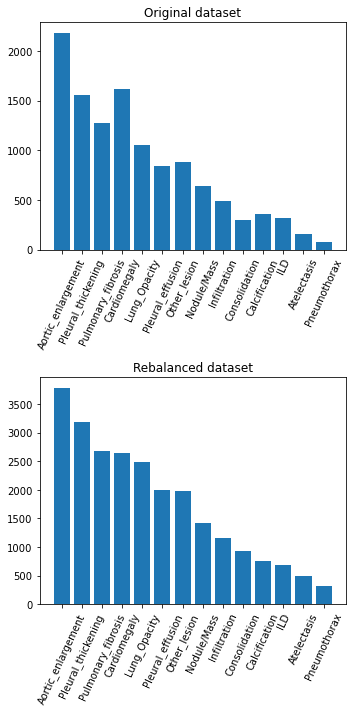

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
axs = axs.flatten()

print(hists)

for i in range(len(hists)):
  hist = hists[i]
  ax = axs[i]
  ax.bar(np.arange(len(_classes)), hist)
  ax.set_xticks(np.arange(len(_classes)), _classes, rotation=65)
  ax.set_title(titles[i])
plt.tight_layout()

In [100]:
hists = hists[::-1]

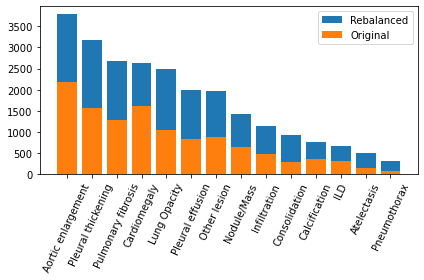

In [114]:
labels = ['Rebalanced', 'Original']
for i in range(len(hists)):
  hist = hists[i]
  plt.bar(np.arange(len(_classes)), hist, label=labels[i])

classes_pretty = [c.replace('_', ' ') for c in _classes]
plt.xticks(np.arange(len(_classes)), classes_pretty, rotation=65)
plt.legend()
plt.tight_layout()
plt.savefig('figures/rebalace.png')

In [161]:
table_pairs = list(zip(percentages, results_avg, results_avg_ar))
for (percentage, metric, metric_ar) in table_pairs:
  if percentage == 100:
    name = 'Baseline'
  else:
    name = f'Pretrained {100 - int(percentage)}\%'
  number_of_examples = int(3075 * (int(percentage) / 100.))
  print(f'{name} & {metric["bbox_mAP"]:.3f} & {metric["bbox_mAP_50"]:.3f} & {metric["bbox_mAP_s"]:.3f} & {metric_ar["AR@100"]:.3f} & {metric_ar["AR_s@1000"]:.3f} & {number_of_examples} \\\\ \\hline')

Baseline & 0.129 & 0.278 & 0.021 & 0.412 & 0.154 & 3075 \\ \hline
Pretrained 10\% & 0.142 & 0.284 & 0.026 & 0.413 & 0.156 & 2767 \\ \hline
Pretrained 20\% & 0.139 & 0.292 & 0.020 & 0.412 & 0.158 & 2460 \\ \hline
Pretrained 30\% & 0.130 & 0.268 & 0.014 & 0.402 & 0.146 & 2152 \\ \hline
Pretrained 40\% & 0.123 & 0.272 & 0.014 & 0.394 & 0.131 & 1845 \\ \hline
Pretrained 50\% & 0.109 & 0.248 & 0.011 & 0.387 & 0.131 & 1537 \\ \hline
Pretrained 60\% & 0.104 & 0.230 & 0.011 & 0.378 & 0.120 & 1230 \\ \hline
Pretrained 70\% & 0.095 & 0.202 & 0.007 & 0.363 & 0.108 & 922 \\ \hline
Pretrained 80\% & 0.081 & 0.178 & 0.006 & 0.338 & 0.089 & 615 \\ \hline
Pretrained 90\% & 0.060 & 0.135 & 0.003 & 0.303 & 0.064 & 307 \\ \hline


In [162]:
print(results_avg_ar[0])

OrderedDict([('AR@100', 0.412), ('AR@300', 0.412), ('AR@1000', 0.412), ('AR_s@1000', 0.154), ('AR_m@1000', 0.431), ('AR_l@1000', 0.562)])


In [297]:
import os
from pathlib import Path
from datetime import datetime
import shutil
from collections import Counter
import warnings
import json

import torch
import torchvision.ops.boxes as bops

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
from ensemble_boxes import weighted_boxes_fusion

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=UserWarning)

all_images_folder = '../vinbigdata/train'

all_annotations = pd.read_csv('../vinbigdata/train.csv')
all_annotations = all_annotations[all_annotations.class_id != 14]
all_annotations['image_path'] = all_annotations['image_id'].map(lambda id:
  os.path.join(all_images_folder, str(id) + '.png'))
normalize_bboxes(all_annotations)
all_image_paths = all_annotations['image_path'].unique()

np.random.seed(1)

indices = np.arange(len(all_image_paths))
np.random.shuffle(indices)

# train, valid, test
splits = [0.7, 0.1, 0.2]
valid_split_index = int((splits[0] + splits[1]) * len(indices))
test_paths = all_image_paths[valid_split_index:]

iou_thr = 0.2

count = np.zeros(20)
count_r9_r10 = 0
count_r9_r11 = 0

viz_images = []
all_rads = []
ious_r9_r10 = []
ious_r9_r11 = []

for i, path in tqdm(enumerate(test_paths)):
    image_basename = Path(path).stem
        
    img_annotations = all_annotations[all_annotations.image_id==image_basename]

    boxes_list = []
    labels_list = []
    rads_list = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())

    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid] > 1:
            anns = img_annotations[img_annotations.class_id==cid]
            cls_list = anns['class_id'].tolist()
            labels_list.append(cls_list)
            anns['rad_id'] = anns['rad_id'].apply(lambda rad_id: int(rad_id.replace('R', '')))
            rads_list.append(anns['rad_id'].to_numpy())
            bbox = anns[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            boxes_list.append(bbox.tolist())

    for i in range(len(boxes_list)):
        bboxes = np.array(boxes_list[i])
        rads = np.array(rads_list[i])
        if 8 in rads:
            bboxes_r9 = bboxes[rads == 8]
            bboxes_r10 = bboxes[rads == 9]
            bboxes_r11 = bboxes[rads == 10]
            for box_r9 in bboxes_r9:
                for box_r10 in bboxes_r10:
                    iou = bops.box_iou(torch.from_numpy(box_r9).unsqueeze(0), torch.from_numpy(box_r10).unsqueeze(0))
                    ious_r9_r10.append(iou.squeeze().item())
                for box_r11 in bboxes_r11:
                    iou = bops.box_iou(torch.from_numpy(box_r9).unsqueeze(0), torch.from_numpy(box_r11).unsqueeze(0))
                    ious_r9_r11.append(iou.squeeze().item())

    if len(rads_list) > 0:
        rads_for_counting = np.unique(np.concatenate(rads_list))
        count[rads_for_counting] += 1
        if 8 in rads_for_counting and 9 in rads_for_counting:
            count_r9_r10 += 1
        if 8 in rads_for_counting and 10 in rads_for_counting:
            count_r9_r11 += 1
        
        if 8 in rads_for_counting:
            if 9 in rads_for_counting:
                count_r9_r10 += 1

print('Image count per radiologist:')
print(count)
print('Examples containing R9 and R10: ' + str(count_r9_r10))
print('Examples containing R9 and R11: ' + str(count_r9_r11))

879it [00:03, 287.73it/s]

Image count per radiologist:
[  0.   0.   0.   0.   0.   0.   0.   0. 777. 770. 773.  26.  17.  30.
  34.  36.  20.   7.   0.   0.]
Examples containing R9 and R10: 1494
Examples containing R9 and R11: 750


In [308]:
ious_r9_r10 = np.array(ious_r9_r10)
ious_r9_r10_thr = ious_r9_r10[ious_r9_r10 > iou_thr]
ious_r9_r10.mean()

0.6890090839344745

In [309]:
ious_r9_r11 = np.array(ious_r9_r11)
ious_r9_r11_thr = ious_r9_r11[ious_r9_r11 > iou_thr]
ious_r9_r11_thr.mean()

0.6742778350842352

In [311]:
print(outputs[:1])

[[array([[2.4480377e+02, 1.4871521e+02, 3.0638422e+02, 2.1541452e+02,
        9.1054463e-01],
       [2.4825928e+02, 1.2668445e+02, 3.1782062e+02, 2.5416461e+02,
        5.9263177e-02]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[1.6496365e+02, 3.2065271e+02, 3.7163541e+02, 3.8714990e+02,
        5.1839161e-01],
       [1.4792639e+02, 3.4549365e+02, 3.9583881e+02, 4.0195776e+02,
        1.2643100e-01]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([[4.1927246e+01, 8.0035202e+01, 2.0415863e+02, 3.9586316e+02,
        1.4881639e-01],
       [9.3447136e+01, 8.6838432e+01, 2.0174976e+02, 2.9196664e+02,
        1.2498847e-01]], dtype=float32), array([], shape=(0, 5), dtype=float32), array([[8.8821808e+01, 8.4653152e+01, 1.8267053e+02, 2.5560002e+02,
        9.0975001e-02],
       [8.2938194e+01, 1.1581673e+02, 2.0401965e+02, 2.0848106e+02,
        6.3069269e-02],
       [8.2236763e+01, 6.7576065e+01, 2.0430392e+02

In [348]:
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps

iou_per_experiment = []

for experiment_name, checkpoint in zip(experiment_names, experiment_checkpoints):
    cfg = get_config()
    args = argparse.Namespace(eval='proposal', out='results/' + experiment_name + '.pkl', checkpoint=None, work_dir=results_dir, fuse_conv_bn=None, 
    gpu_ids=None, format_only=None, show=None, show_dir=None, show_score_thr=0.3, gpu_collect=None,
    tmpdir=None, cfg_options=None, options=None, launcher='none', eval_options=None, local_rank=0)
    dataset, outputs = mmdet_test.get_outputs(cfg, checkpoint, args)

    result_files, tmp_dir = dataset.format_results(outputs, '')
    predictions = mmcv.load(result_files['bbox'])

    ious = []

    for i in range(len(dataset.img_ids)):
        ann_ids = dataset.coco.get_ann_ids(img_ids=dataset.img_ids[i])
        ann_info = dataset.coco.load_anns(ann_ids)
        img_predictions = [p for p in predictions if p['image_id'] == dataset.img_ids[i]]
        for pred in img_predictions:
            pred['bbox'][2] += pred['bbox'][0]
            pred['bbox'][3] += pred['bbox'][1]
        if len(ann_info) == 0:
            continue
        for ann in ann_info:
            if ann.get('ignore', False) or ann['iscrowd']:
                continue
            iou = 0
            ann['bbox'][2] += ann['bbox'][0]
            ann['bbox'][3] += ann['bbox'][1]
            for pred in img_predictions:
                if pred['category_id'] == ann['category_id']:
                    iou_pred = bops.box_iou(torch.tensor(pred['bbox']).unsqueeze(0), torch.tensor(ann['bbox']).unsqueeze(0))
                    if iou_pred.item() > iou:
                        iou = iou_pred.item()
            
            ious.append(iou)
    
    iou_per_experiment.append(ious)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/baseline/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 44.2 task/s, elapsed: 20s, ETA:     0sloading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/pretrain10/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 44.1 task/s, elapsed: 20s, ETA:     0sloading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/pretrain20/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 44.0 task/s, elapsed: 20s, ETA:     0sloading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/pretrain30/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 43.8 task/s, elapsed: 20s, ETA:     0sloading annotations into memory...
Done (t=0.01s)
creating

In [349]:
for (experiment_name, ious_for_experiment) in zip(experiment_names, iou_per_experiment):
  mean_iou = np.array(ious_for_experiment).mean()
  print(f'{experiment_name}: {mean_iou:.3f}')

baseline: 0.565
pretrain10: 0.566
pretrain20: 0.565
pretrain30: 0.555
pretrain40: 0.545
pretrain50: 0.536
pretrain60: 0.527
pretrain70: 0.507
pretrain80: 0.479
pretrain90: 0.438
